# Previsione a 14 giorni

Previsione a 14 giorni con modelli SARIMA.

> Max Pierini

**NB: questo articolo è un progetto aperto e ancora in fase di revisione e completamento. Per proposte di collaborazione, scrivere a info@epidata.it**

***

In [1]:
# REFERENCES
#
# https://www.youtube.com/watch?v=Y2khrpVo6qI
# https://www.lorenzogovoni.com/modello-arima/
# https://otexts.com/fpp2/seasonal-arima.html
# https://otexts.com/fpp2/non-seasonal-arima.html
# http://people.duke.edu/~rnau/seasarim.htm
# https://robjhyndman.com/hyndsight/monthly-seasonality/
# http://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html#pmdarima.arima.auto_arima
# http://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.ARIMA.html#pmdarima.arima.ARIMA.predict
# https://www.datageeko.com/time-series-from-arima-to-deep-learning-part-1/
# http://www.phdeconomics.sssup.it/documents/Lesson13.pdf
# https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/
# https://medium.com/@remycanario17/tests-for-heteroskedasticity-in-python-208a0fdb04ab
# https://www.youtube.com/watch?v=Y2khrpVo6qI

In [2]:
import numpy as np
import pandas as pd
#import itertools
#from pandas.plotting import autocorrelation_plot

import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.tsa.api import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

#import pmdarima as pa

import scipy.stats as sps
from scipy.signal import welch, argrelextrema, periodogram, spectrogram

#from sklearn.ensemble import GradientBoostingRegressor
#from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
#from sklearn.inspection import permutation_importance
#import scipy.stats as sps

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
sns.set()

from IPython.display import Markdown

In [3]:
df = pd.read_csv(
    'https://github.com/pcm-dpc/COVID-19/raw/master/dati-andamento-nazionale/'
    'dpc-covid19-ita-andamento-nazionale.csv',
    parse_dates=['data'], index_col='data'
)

In [4]:
df.index = df.index.normalize()

In [5]:
ts = df[['nuovi_positivi']].dropna()

In [6]:
sts = ts.nuovi_positivi
sts.index.name = None

In [7]:
ts_log = np.log(sts).dropna()

In [8]:
auto_sarima_params = {
    'maxiter': 50,
    'method': 'lbfgs',
    'order': (1, 1, 2),
    'out_of_sample_size': 0,
    'scoring': 'mse',
    'scoring_args': {},
    'seasonal_order': (1, 0, 1, 7),
    #'start_params': [.95, -1.5, 0.64, .97, -.77, .04],
    'suppress_warnings': True,
    'trend': None,
    'with_intercept': False,
    #'enforce_stationarity': False,
    #'enforce_invertibility': False
}
fit_params = {
    'suppress_warning': True,
    'method': 'lbfgs',
    'start_params': [.95, -1.5, 0.64, .97, -.77, .04],
}

In [9]:
_ = """
auto_arima = pa.ARIMA(
    **auto_sarima_params
).fit(
    ts_log,
)
auto_arima.summary()"""

In [10]:
sarimax = SARIMAX(
    ts_log,
    **auto_sarima_params,
    
).fit(
    **fit_params
)

I nuovi casi giornalieri previsti a 14 giorni sono stimati utilizzando un modello di autoregressione SARIMA ovvero $\mathrm{ARIMA}(p,d,q)(P,D,Q)[s]$ sul logaritmo dei nuovi positivi, i cui parametri ottimali sono stati determinati per grid-search (vedi oltre per dettagli).

In modello migliore è attualmente

$$
\mathrm{ARIMA}(1, 1, 2)(1, 0, 1)[7]
$$

I parametri potrebbero essere ulteriormente affinati con successive grid-search mirate.

In [11]:
alpha = .5  # change to .68 to be near SD
CI_lo = alpha / 2
CI_hi = 1 - CI_lo
CI = 1 - alpha

In [12]:
predict_future_log = sarimax.get_forecast(14).summary_frame()

predict_future_dist = sps.norm(loc=predict_future_log['mean'], scale=predict_future_log['mean_se'])
predict_future = np.exp(predict_future_log[['mean']])
predict_future_lo = np.exp(predict_future_dist.ppf(CI_lo))
predict_future_hi = np.exp(predict_future_dist.ppf(CI_hi))

predict_future['lo'] = predict_future_lo
predict_future['hi'] = predict_future_hi
predict_future.columns = ['mu', 'lo', 'hi']

predict_future_log_x = np.linspace(predict_future_dist.ppf(.01), predict_future_dist.ppf(.99))
predict_future_x = np.exp(predict_future_log_x)
predict_future_y = predict_future_dist.pdf(predict_future_log_x)
predict_future_y /= predict_future_y.max(axis=0)

In [13]:
predict_past_log = sarimax.get_prediction().summary_frame()

predict_past_dist = sps.norm(loc=predict_past_log['mean'], scale=predict_past_log['mean_se'])
predict_past = np.exp(predict_past_log[['mean']])
predict_past_lo = np.exp(predict_past_dist.ppf(CI_lo))
predict_past_log_hi = predict_past_dist.ppf(CI_hi)
predict_past_log_hi[predict_past_log_hi>100] = np.nan
predict_past_hi = np.exp(predict_past_log_hi)

predict_past['lo'] = predict_past_lo
predict_past['hi'] = predict_past_hi
predict_past.columns = ['mu', 'lo', 'hi']
predict_past.replace(np.inf, np.nan, inplace=True)

# Previsioni

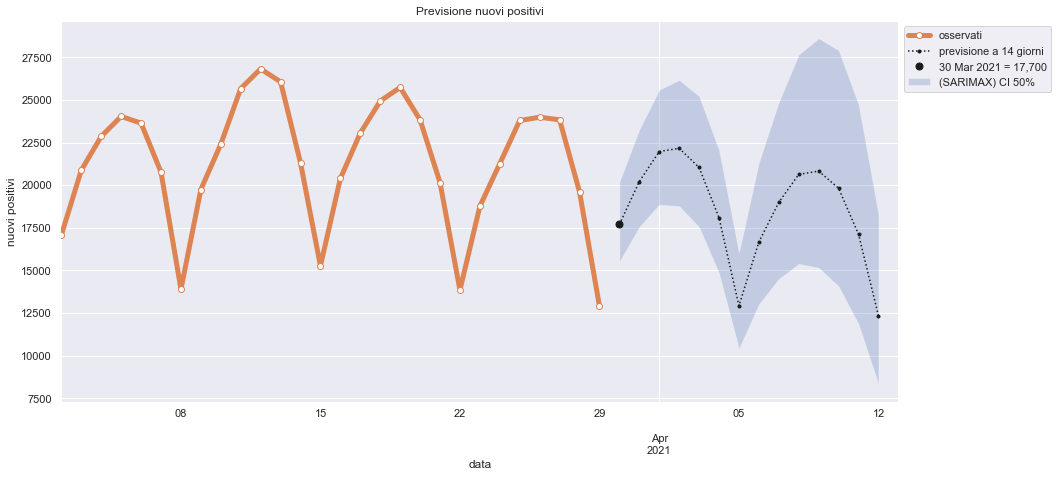

In [14]:
ax = df.iloc[-28:].nuovi_positivi.plot(
    lw=5, marker='o', mfc='w',
    label='osservati', figsize=(15, 7), zorder=100, color='C1'
)
ax.plot(predict_future.index, predict_future.mu, color='k', ls=':', marker='.', label='previsione a 14 giorni')
ax.plot(
    predict_future.index[0], predict_future.mu[0], marker='o', ms=7, ls='none', color='k', 
    label=f"{predict_future.index[0].date().strftime('%d %b %Y')} = {predict_future.mu[0]:,.0f}")
ax.fill_between(
    predict_future.index, predict_future.lo, predict_future.hi,
    alpha=.25, label=f'(SARIMAX) CI {CI:.0%}'
)

ax.set_xlim(ax.get_xlim()[0], predict_future.index[-1] + pd.Timedelta(days=1))
ax.set(
    title=f'Previsione nuovi positivi',
    ylabel='nuovi positivi'
)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

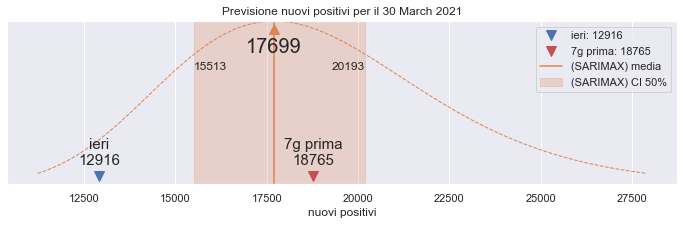

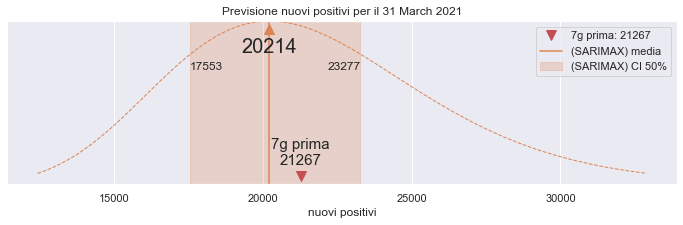

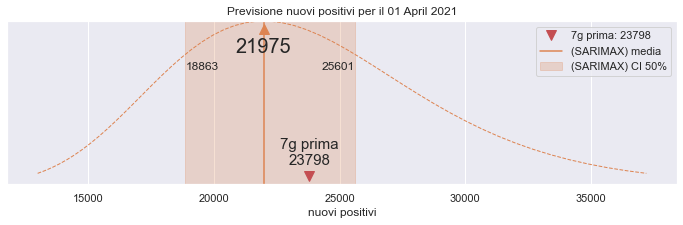

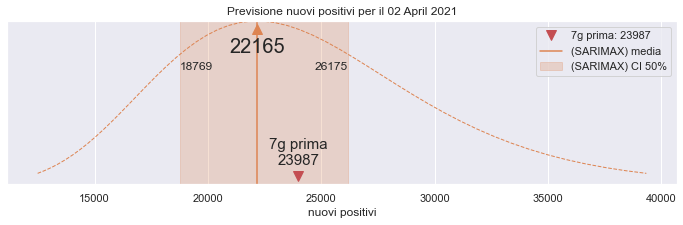

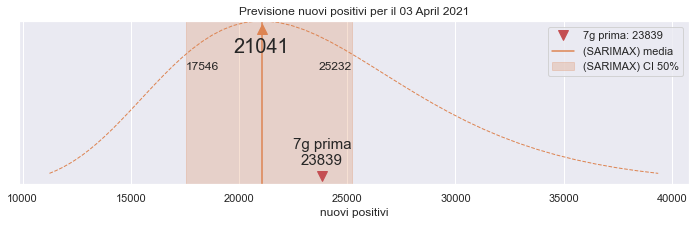

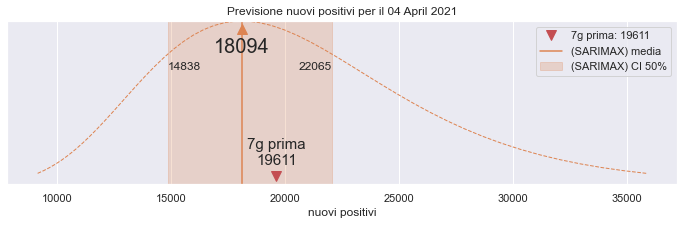

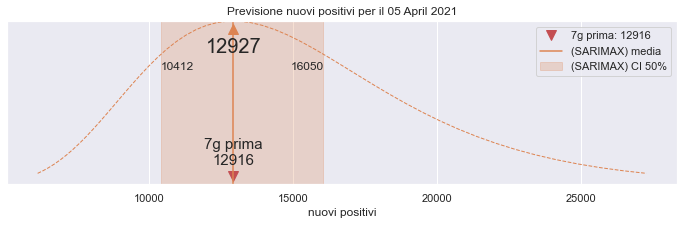

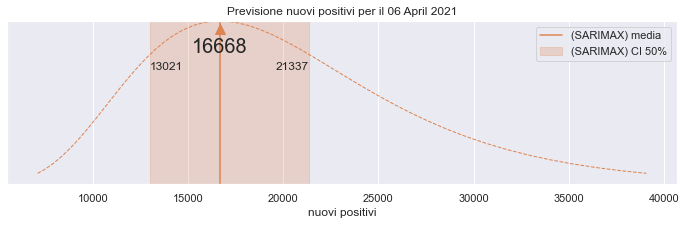

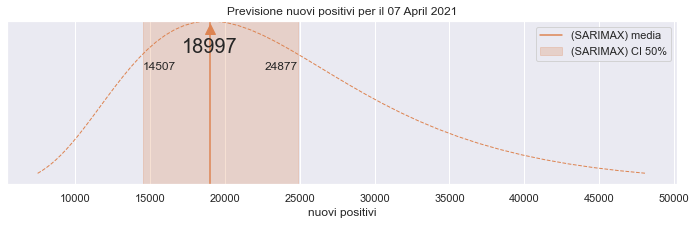

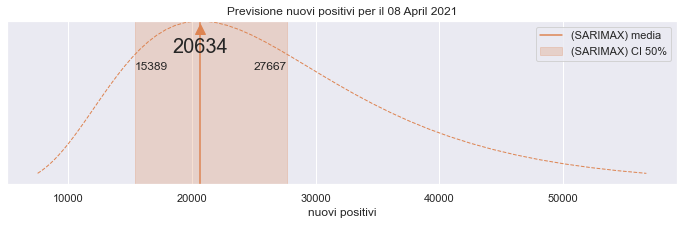

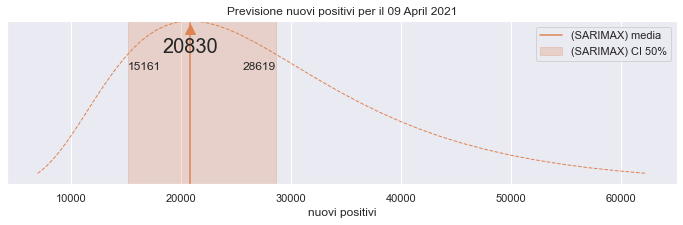

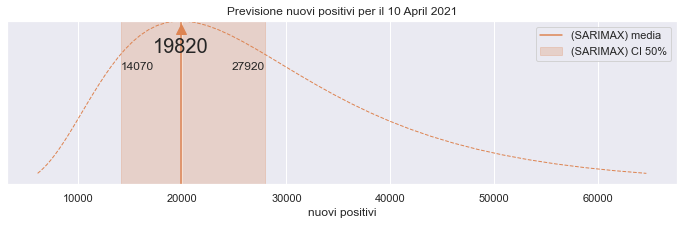

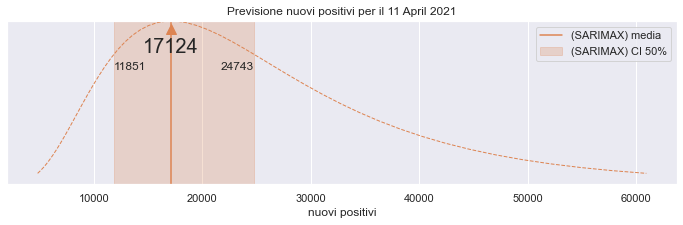

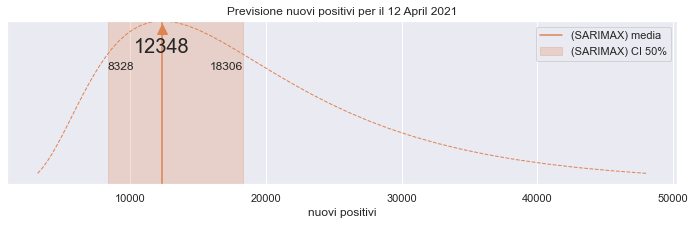

In [15]:
for i in range(predict_future_x.shape[1]):
    fig, ax = plt.subplots(figsize=(12, 3))

    ylim = ax.get_ylim()
    ax.fill_betweenx(
        [0, 1],
        predict_future.lo[i], predict_future.hi[i],
        alpha=.25, label=f'(SARIMAX) CI {CI:.0%}',
        color='C1'
    )
    ax.plot(predict_future_x[:,i], predict_future_y[:,i], lw=1, ls='--', color='C1')
    if not i:
        ax.plot(ts.iloc[-1], .05, marker='v', color='C0', ls='none', 
                ms=10, label=f"ieri: {ts.iloc[-1].values[0]}")
        ax.text(
            ts.iloc[-1], .1,
            f"ieri\n{ts.iloc[-1].values[0]}", 
            ha='center', va='bottom', fontsize=15
        )
    if i < 7:
        ax.plot(ts.iloc[-7+i], .05, marker='v', color='r', ls='none', 
                ms=10, label=f"7g prima: {ts.iloc[-7+i].values[0]}")
        ax.text(
            ts.iloc[-7+i], .1,
            f"7g prima\n{ts.iloc[-7+i].values[0]}", 
            ha='center', va='bottom', fontsize=15
        )

    ax.plot(predict_future.mu[i], .95, marker='^', color='C1', ls='none', ms=10)
    ax.text(predict_future.mu[i], .90, int(predict_future.mu[i]), ha='center', va='top', fontsize=20)
    ax.text(predict_future.lo[i], .75, int(predict_future.lo[i]), ha='left', va='top', fontsize=12)
    ax.text(predict_future.hi[i], .75, int(predict_future.hi[i]), ha='right', va='top', fontsize=12)
    
    ax.axvline(predict_future.mu[i], color='C1', label='(SARIMAX) media')

    ax.legend(loc='upper right')
    ax.set(
        ylim=ylim, yticks=[],
        xlabel='nuovi positivi',
        title=f'Previsione nuovi positivi per il {predict_future.index[i].strftime("%d %B %Y")}',
    )
    plt.show()

# Metodo

## SARIMA

I modelli ARIMA vengono solitamente scritti in forma semplificata

$$
\mathrm{ARIMA}(p,d,q)(P,D,Q)[s]
$$

dove 

- $(p,d,q)$ sono rispettivamente gli iperparametri di auto regressione (AR), derivata (I) e media mobile (MA) della porzione non stagionale

- $(P,D,Q)[s]$ sono rispettivamente gli iperparametri di auto regressione (AR), derivata (I) e media mobile (MA) della porzione con stagionalità $s$

e che in forma di operatori polinomiali corrisponde a

$$
\phi_p(B)\Phi_P(B^s)(1-B)^d(1-B^s)^D x_t = \theta_q(B) \Theta_Q (B^s) \varepsilon_t
$$

in cui

- $x_t$ è l'osservazione della variabile $x$ al tempo $t$

- $\varepsilon_t$ è il rumore bianco $\varepsilon$ al tempo $t$ ed è [identicamente e indipendentemente distribuito](https://online.stat.psu.edu/stat510/lesson/2/2.1) normale con media 0 e varianza $\sigma^2$ ovvero $\varepsilon \overset{iid}{\sim} \mathcal{N}(0, \sigma^2)$

- l'[operatore di back-shift](https://otexts.com/fpp2/backshift.html) $B^i$ è tale per cui $B^i y_t = y_{t-i}$ e pertanto i termini $(1 - B^i)^j y_t$ sono la derivata di ordine $j$ di $y_{t-i}$ infatti dove ad esempio $j=1$ otteniamo $(1 - B^i) y_t = y_{t-i} - y_{t-i-1}$

- gli operatori $\phi_p(\cdot)$ e $\theta_q(\cdot)$ sono rispettavemente operatori polinomiali di autoregressione AR e media mobile MA, di ordine $p$ e $q$, della porzione non stagionale

- gli operatori $\Phi_P(\cdot)$ e $\Theta_Q(\cdot)$ sono rispettavemente operatori polinomiali di autoregressione AR e media mobile MA, di ordine $P$ e $Q$, della porzione stagionale

Un [operatore polinomiale](https://link.springer.com/chapter/10.1007%2F978-3-030-63823-8_84) $O_i(B^j)$ corrisponde a

$$
O_i(B^j) = 1 - \sum_{k=1}^{i} O_k B^{kj}
$$

dove $O_k$ è il coefficiente di $B^{kj}$.

Il modello da noi scelto (come vedremo più avanti) corrisponde a 

$$
\mathrm{ARIMA}(1,1,2)(1,0,2)[7]
$$

quindi

$$
\mathrm{ARIMA}(p_{=1},d_{=1},q_{=2})(P_{=1},D_{=0},Q_{=1})[s_{=7}]
$$

Sostituendo $(p,d,q)(P,D,Q)[s]$ nell'equazione a operatori polinomiali otteniamo

$$
\phi_1(B)\Phi_1(B^7)(1-B)^1(1-B^7)^0 x_t = \theta_2(B) \Theta_1 (B^7) \varepsilon_t
$$

che possiamo semplificare in

$$
\phi_1(B)\Phi_1(B^7)(1-B) x_t = \theta_2(B) \Theta_1 (B^7) \varepsilon_t
$$

Svolgendo gli operatori polinomiali AR e MA delle porzioni non stagionale e stagionale otteniamo pertanto il processo

$$
(1- \phi_1 B)(1 - \Phi_1 B^7)(1 - B) x_t = (1 - \theta_1B - \theta_2B^2)(1 - \Theta_1B^7) \varepsilon_t
$$

ovvero

$$
(-\phi_1\Phi_1B^9 + \phi_1\Phi_1B^8 + \Phi_1B^8 - \Phi_1B^7 + \phi_1B^2 - \phi_1B - B + 1) x_t
\\
=
\\
(\theta_1 \Theta_1 B^8 + \theta_2 \Theta_1 B^9 -
\Theta_1 B^7  - \theta_1 B  - \theta_2 B^2  + 1) \varepsilon_t
$$

Espandendo gli operatori di back-shift

$$
-\phi_1\Phi_1x_{t-9} + \phi_1\Phi_1x_{t-8} + \Phi_1x_{t-8} - \Phi_1x_{t-7} + \phi_1x_{t-2} - \phi_1x_{t-1} - x_{t-1} + x_t
\\
=
\\
\theta_1 \Theta_1 \varepsilon_{t-8} + \theta_2 \Theta_1 \varepsilon_{t-9} -
\Theta_1 \varepsilon_{t-7}  - \theta_1 \varepsilon_{t-1}  - \theta_2 \varepsilon_{t-2}  + \varepsilon_{t}
$$

da cui otteniamo l'equazione esplicita

$$
\begin{align*}
x_t & = x_{t-1} \\
 & + \phi_1 x_{t-1} - \phi_1 x_{t-2} \\
 & + \Phi_1 x_{t-7} - \Phi_1 x_{t-8} - \phi_1\Phi_1 x_{t-8} + \phi_1\Phi_1 x_{t-9} \\
 & + \varepsilon_{t} - \theta_1 \varepsilon_{t-1} - \theta_2 \varepsilon_{t-2} \\
 & - \Theta_1\varepsilon_{t-7} + \theta_1 \Theta_1 \varepsilon_{t-8} + \theta_2 \Theta_1 \varepsilon_{t-9}
\end{align*}
$$

che possiamo infine semplificare in 

$$
\begin{align*}
x_t  & = x_{t-1} \\
 & + \phi_1 (x_{t-1} - x_{t-2}) \\
 & + \Phi_1 (x_{t-7} -  x_{t-8}) - \Phi_1 \phi_1 (x_{t-8} - x_{t-9}) \\
 & + \varepsilon_{t} - \theta_1 \varepsilon_{t-1} - \theta_2 \varepsilon_{t-2} \\
 & - \Theta_1\varepsilon_{t-7} + \Theta_1 ( \theta_1 \varepsilon_{t-8} + \theta_2 \varepsilon_{t-9})
\end{align*}
$$

dove i rumori bianchi $\varepsilon_t$ sono identicamente e indipendentemente distribuiti normali con media 0 e varianza $\sigma^2$, ovvero $\varepsilon_t \overset{iid}{\sim} \mathcal{N}(0, \sigma^2)$.

Abbiamo pertanto solamente 6 coefficienti (vedi [statsmodels](https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html)).

I coefficienti della porzione non stagionale
- $\phi_1$, coefficiente dell'autoregressione AR, corripondente ad `ar.L1`
- $\theta_1$, coefficiente della media mobile MA, corripondente ad `ma.L1`
- $\theta_2$, coefficiente della media mobile MA, corripondente ad `ma.L2`

I coefficienti della porzione stagionale
- $\Phi_1$, coefficiente dell'autoregressione AR, corripondente ad `ar.S.L7`
- $\Theta_1$, coefficiente della media mobile MA, corripondente ad `ma.S.L7`

La varianza del rumore bianco $\varepsilon_t$
- $\sigma^2$ corripondente a `sigma2`

In [16]:
def get_stationarity(ts, window, mdl):
    # rolling
    r_mu = ts.rolling(window=window, center=True).mean().dropna()
    r_sd = ts.rolling(window=window, center=True).std().dropna()
    r_va = ts.rolling(window=window, center=True).var().dropna()
    exog = ts.values.ravel().reshape(-1, 1)
    resid = mdl.resid
    #white_test = sms.diagnostic.het_white(mdl.resid, mdl.model.exog)
    bp_test = sms.diagnostic.het_breuschpagan(resid, exog)
    #labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
    #print('White Test:\n', dict(zip(labels, white_test)))
    #print('Breusch-Pagan Test:\n', dict(zip(labels, bp_test)))
    sea = seasonal_decompose(ts)
    result = adfuller(ts, autolag='AIC')
    
    fig = plt.figure(constrained_layout=True, figsize=(15, 7))
    gs = GridSpec(2, 4, figure=fig)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1:])
    
    ax30 = fig.add_subplot(gs[1, 0])
    ax31 = fig.add_subplot(gs[1, 1:3])
    #ax32 = fig.add_subplot(gs[1, 2])
    ax33 = fig.add_subplot(gs[1, 3])

    #ax1.plot(r_mu, r_va, marker='o', ls='none', alpha=.5)
    mu_va = pd.DataFrame({'moving average': r_mu.values.ravel(), 'moving variance': r_va.values.ravel(),})
    sns.regplot(
        data=mu_va, x='moving average', y='moving variance',
        line_kws=dict(color='r'), scatter_kws=dict(alpha=.5),
        ax=ax1
    )
    ax1.set(
        title='Finestra 7 giorni',
        xlabel='media mobile', ylabel='varianza mobile'
    )
    ts.plot(
        ax=ax2, label='observations', 
        title=f"Dickey-Fuller test per stazionarietà $p$-value: {result[1]}"
    )
    r_mu.plot(ax=ax2, label='rolling mean')
    r_sd.plot(ax=ax2, label='rolling Std')
    ax2.legend()
    
    ax30.plot(exog, resid, marker='.', alpha=.5, ls='none')
    bp_text = f"{bp_test[-1]:.6f}" if bp_test[-1] > .01 else f"{bp_test[-1]:.6e}"
    ax30.set(
        title=f'Breusch-Pagan $p$-value: {bp_text}',
        xlabel='osservazioni', ylabel='SARIMA residuals'
    )
    
    sea.trend.plot(ax=ax31, title='trend')
    sea.seasonal.plot(ax=ax33, xlim=(sea.seasonal.index[0], sea.seasonal.index[7*4]), title='stagionalità')
    #sea.resid.plot(ax=ax33, marker='.', ls='none', title='residuals')
    
    plt.show()
    # Dickey-Fuller test
    #print("===========> Dickey-Fuller test")
    #result = adfuller(ts, autolag='AIC')
    #print('ADF stat:', result[0])
    #print('p-value:', result[1])
    #print('Used lags:', result[2])
    #print('Observations:', result[3])
    #print('Criticals')
    #for k, v in result[4].items():
    #    print('\t', k, v)

Notiamo tre caratteristiche dei dati di cui è necessario tener conto prima di procedere alla scelta del modello SARIMA:

1. **Eteroschedasticità**: la varianza aumenta all'aumentare della media; il test di Breusch-Pagan infatti ritorna un $p$-value notevolmente inferiore al più alto livello di significatività (0.1)
2. **Non-stazionarietà**: i dati non sono stazionari ma presentano un chiaro trend non lineare; il test di Dickey-Fuller infatti ritorna un $p$-value superiore al più alto livello di significatività (0.1)
3. **Stagionalità**: è chiaramente visibile una variazione ciclica (stagionale) di 7 giorni

I modelli SARIMA possono gestire la non-stazionarietà utilizzando la derivata delle osservazioni (parametro $d$) e la stagionalità tramite i parametri $(P,D,Q)[s]$ ma non possono migliorare l'eteroschedasticità.

/Users/massimopierini/anaconda3/envs/covid/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


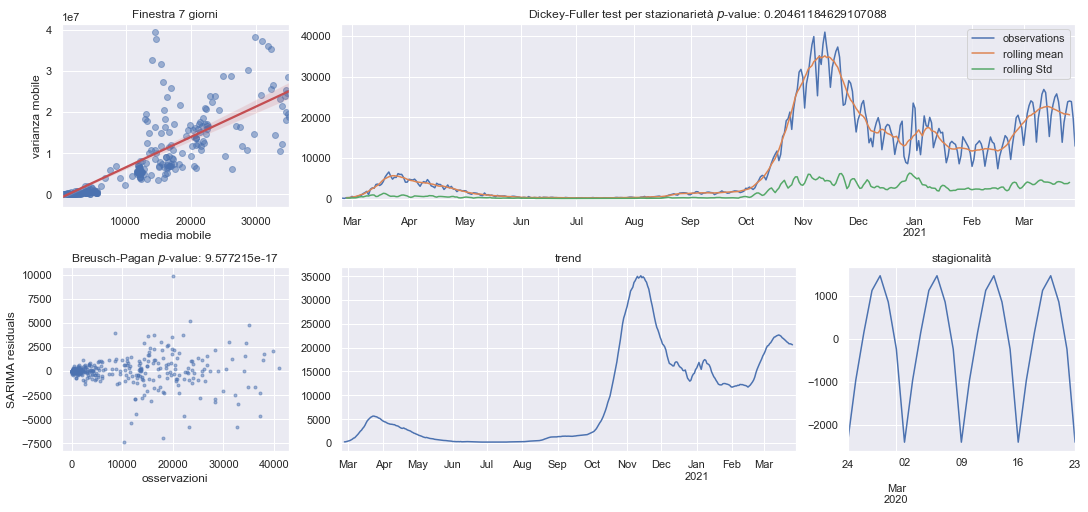

In [17]:
arima_model_ori = SARIMAX(
    sts,
    **auto_sarima_params
).fit(
    **fit_params
)
#arima_model_fit_ori = arima_model_ori.fit(sts)
get_stationarity(sts, 7, arima_model_ori)

Per ovviare all'eteroschedasticità, trasformiamo dunque i dati prendendo il logaritmo dei nuovi positivi.

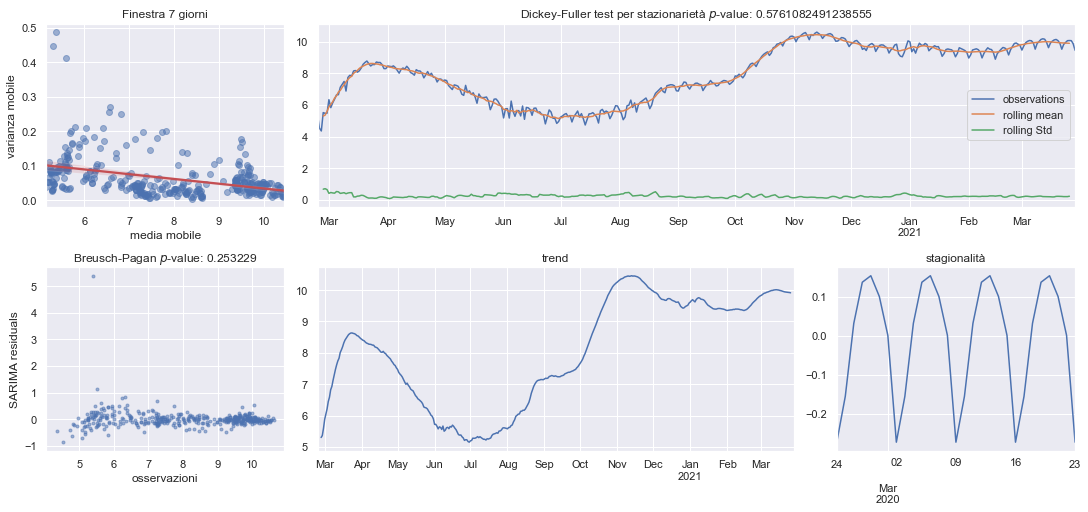

In [18]:
get_stationarity(ts_log, 7, sarimax)

Il test di Breusch-Pagan è ora più che soddifacente, dunque verifichiamo che l'utilizzo della derivata prima delle osservazioni sia in grado di risolvere il trend non lineare.

Come notiamo, il test di Dickey-Fuller sulla derivata prima ritorna un $p$-value è accettabile (minore di 0.01).

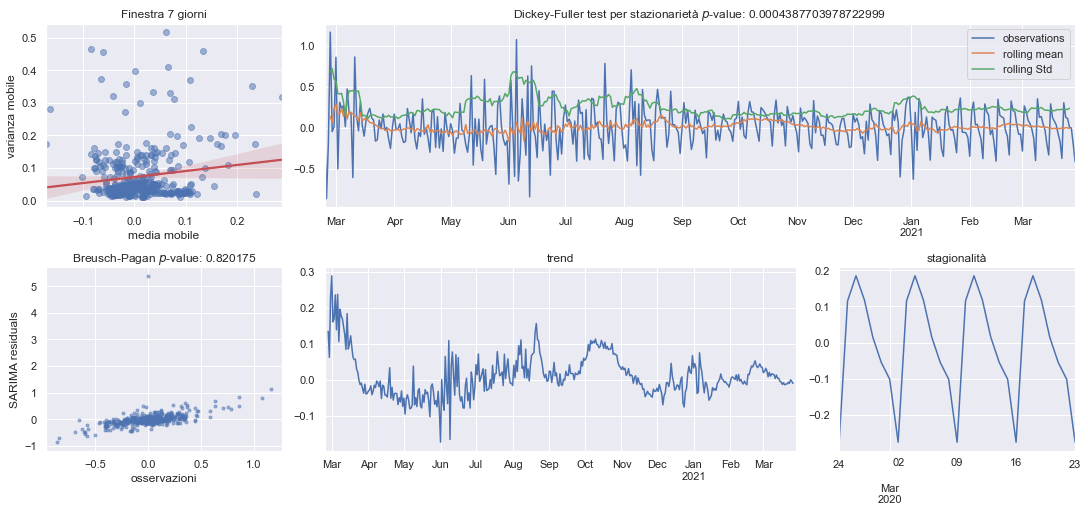

In [19]:
get_stationarity(ts_log.diff().fillna(0), 7, sarimax)

In [20]:
def welch_analysis(df, fd=None, period=4, denom=4,
                   significative=[1],
                   max_xlim=1.95, fs=1.0,
                   nharmonics=0, nfft=2**16,
                   sample_rate='daily', basis='hours',
                   title='Sample',
                   min_harm_mode=2, hertz=False,
                   harm_rot=0
                   ):

    if fd is None:
        fd = df.diff()[1:]

    _f, _p = periodogram(
        fd.values.ravel(),
        fs=fs,
        detrend='linear', 
        nfft=nfft, 
        scaling='density'
    )
    
    periods = 1 / _f[1:]
    density = _p[1:] / _p[1:].max()
    
    fig, ax = plt.subplots(figsize=(15, 4))

    xlim=(max(period/(nharmonics+1), max_xlim), period*2)
    
    good_periods = periods[(periods>xlim[0])&(periods<xlim[1])]
    good_density = density[(periods>xlim[0])&(periods<xlim[1])]

    good_density /= good_density.max()
    ax.plot(good_periods, good_density, color='k', lw=1)
    ax.set(
        xlim=xlim,
        ylim=(-.05, 1.1),
        xscale='log', 
        xticks=[],  xticklabels=[], 
        title=f'{title}'
    )

    harmonics = period / np.arange(1, nharmonics+2, 1)
    for i, harm_mode in enumerate(harmonics[:-1]):
        if harm_mode < min_harm_mode:
            continue
        ax.text(
            harm_mode, -.05, 
            f"{harm_mode/denom:.1f}\n{i+1}°" if not hertz else f"{1/(harm_mode/denom):.1f}\n{i+1}°",
            ha='center', va='top',
            rotation=harm_rot
        )
        ax.text(
            harm_mode, 1.05,
            '@' if (i+1) in significative else 'X', 
            fontsize=12,
            ha='center', va='center'
        )

    plt.show()

Confermiamo infine la stagionalità settimanale con un periodogramma della derivata prima del logaritmo dei nuovi positivi, da cui si nota la fondamentale (primo armonico) di periodo $7$ giorni, il secondo e terzo armonico di $3.5$ e $2.\bar{3}$ giorni.

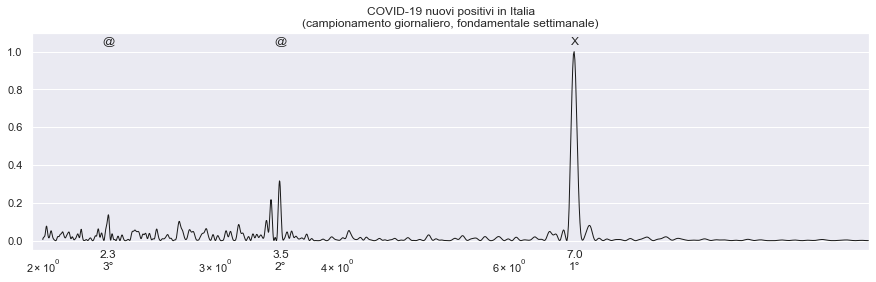

In [21]:
test_it_harm = welch_analysis(
    ts_log, period=7, denom=1,
    nfft=2**12,
    significative=[2, 3, 4, 5, 6, 8, 9, 10, 11, 12],
    nharmonics=12, 
    title="COVID-19 nuovi positivi in Italia\n(campionamento giornaliero, fondamentale settimanale)",
)

Per il modello SARIMA utilizzeremo pertanto:

- la derivata prima $d=1$ del logaritmo dei nuovi positivi $Y=\log(y)$
- una stagionalità di 7 giorni ($s=7$)

e procederemo alla scelta del miglior modello che minimizzi il Bayesian Information Criterion per grid-search con `pmdarima`.

In [22]:
# codice per riprodurre la grid-search del modello SARIMAX
_ = """
auto_sarima = pa.auto_arima(
    ts_log,
    # ARIMA parameters
    d=1,
    # Seasonal parameters
    seasonal=True, m=7,
    # settings
    information_criterion='bic',
    trace=True,
    maxiter=50,
    suppress_warnings=True,
    alpha=.01,
    with_intercept=False,
    enforce_stationarity=False, 
    enforce_invertibility=False,
)
auto_sarima_params = auto_sarima.get_params()"""

In [23]:
print("""
Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,0,1)[7]             : BIC=-91.111, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[7]             : BIC=78.759, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[7]             : BIC=-29.669, Time=0.06 sec
 ARIMA(0,1,1)(0,0,1)[7]             : BIC=7.598, Time=0.05 sec
 ARIMA(2,1,2)(0,0,1)[7]             : BIC=22.647, Time=0.16 sec
 ARIMA(2,1,2)(1,0,0)[7]             : BIC=-43.768, Time=0.20 sec
 ARIMA(2,1,2)(2,0,1)[7]             : BIC=-85.448, Time=0.82 sec
 ARIMA(2,1,2)(1,0,2)[7]             : BIC=-85.474, Time=0.92 sec
 ARIMA(2,1,2)(0,0,0)[7]             : BIC=27.054, Time=0.23 sec
 ARIMA(2,1,2)(0,0,2)[7]             : BIC=-11.985, Time=0.37 sec
 ARIMA(2,1,2)(2,0,0)[7]             : BIC=-69.422, Time=0.28 sec
 ARIMA(2,1,2)(2,0,2)[7]             : BIC=-79.335, Time=1.07 sec
 ARIMA(1,1,2)(1,0,1)[7]             : BIC=-116.824, Time=0.42 sec
 ARIMA(1,1,2)(0,0,1)[7]             : BIC=16.722, Time=0.17 sec
 ARIMA(1,1,2)(1,0,0)[7]             : BIC=-54.235, Time=0.25 sec
 ARIMA(1,1,2)(2,0,1)[7]             : BIC=-110.995, Time=0.69 sec
 ARIMA(1,1,2)(1,0,2)[7]             : BIC=-110.983, Time=0.87 sec
 ARIMA(1,1,2)(0,0,0)[7]             : BIC=69.728, Time=0.08 sec
 ARIMA(1,1,2)(0,0,2)[7]             : BIC=-17.942, Time=0.39 sec
 ARIMA(1,1,2)(2,0,0)[7]             : BIC=-83.396, Time=0.37 sec
 ARIMA(1,1,2)(2,0,2)[7]             : BIC=-105.061, Time=1.12 sec
 ARIMA(0,1,2)(1,0,1)[7]             : BIC=-97.263, Time=0.19 sec
 ARIMA(1,1,1)(1,0,1)[7]             : BIC=-95.694, Time=0.21 sec
 ARIMA(1,1,3)(1,0,1)[7]             : BIC=-112.048, Time=0.61 sec
 ARIMA(0,1,1)(1,0,1)[7]             : BIC=-99.013, Time=0.14 sec
 ARIMA(0,1,3)(1,0,1)[7]             : BIC=-96.402, Time=0.28 sec
 ARIMA(2,1,1)(1,0,1)[7]             : BIC=-96.813, Time=0.27 sec
 ARIMA(2,1,3)(1,0,1)[7]             : BIC=-106.140, Time=0.67 sec
 ARIMA(1,1,2)(1,0,1)[7] intercept   : BIC=-106.650, Time=0.67 sec

Best model:  ARIMA(1,1,2)(1,0,1)[7]          
Total fit time: 12.051 seconds
""")


Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,0,1)[7]             : BIC=-91.111, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[7]             : BIC=78.759, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[7]             : BIC=-29.669, Time=0.06 sec
 ARIMA(0,1,1)(0,0,1)[7]             : BIC=7.598, Time=0.05 sec
 ARIMA(2,1,2)(0,0,1)[7]             : BIC=22.647, Time=0.16 sec
 ARIMA(2,1,2)(1,0,0)[7]             : BIC=-43.768, Time=0.20 sec
 ARIMA(2,1,2)(2,0,1)[7]             : BIC=-85.448, Time=0.82 sec
 ARIMA(2,1,2)(1,0,2)[7]             : BIC=-85.474, Time=0.92 sec
 ARIMA(2,1,2)(0,0,0)[7]             : BIC=27.054, Time=0.23 sec
 ARIMA(2,1,2)(0,0,2)[7]             : BIC=-11.985, Time=0.37 sec
 ARIMA(2,1,2)(2,0,0)[7]             : BIC=-69.422, Time=0.28 sec
 ARIMA(2,1,2)(2,0,2)[7]             : BIC=-79.335, Time=1.07 sec
 ARIMA(1,1,2)(1,0,1)[7]             : BIC=-116.824, Time=0.42 sec
 ARIMA(1,1,2)(0,0,1)[7]             : BIC=16.722, Time=0.17 sec
 ARIMA(1,1,2)(1,0,0)[7]             : BIC=-54.235, 

In [24]:
sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                      nuovi_positivi   No. Observations:                  400
Model:             SARIMAX(1, 1, 2)x(1, 0, [1], 7)   Log Likelihood                  80.367
Date:                             Mon, 29 Mar 2021   AIC                           -148.735
Time:                                     21:44:12   BIC                           -124.801
Sample:                                 02-24-2020   HQIC                          -139.256
                                      - 03-29-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9467      0.020     47.658      0.000       0.908       0.986
ma.L1         -1.5649      0.036    -43.786      0.000      -1.635      -1.495
ma.L2          0.6458      0.033     19.590      0.000       0.581       0.710
ar.S.L7        0.9753      0.010     99.766      0.000       0.956       0.994
ma.S.L7       -0.7725      0.037    -20.834      0.000      -0.845      -0.700
sigma2         0.0382      0.002     18.943      0.000       0.034       0.042
===================================================================================
Ljung-Box (L1) (Q):                   0.91   Jarque-Bera (JB):                92.53
Prob(Q):                              0.34   Prob(JB):                         0.00
Heteroskedasticity (H):               0.23   Skew:                             0.34
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [25]:
_CI = .99
_a = (1 - _CI) / 2
s_pars = sarimax.params.reset_index()
s_pars.columns = ['index', 'mu']
s_conf = sarimax.conf_int(alpha=_a)
s_conf.columns = [f'lo {_CI:.0%}', f'hi {_CI:.0%}']
s_conf.reset_index(inplace=True)

In [26]:
s_pars_df = s_pars.merge(
    s_conf,
    on='index'
).set_index('index')

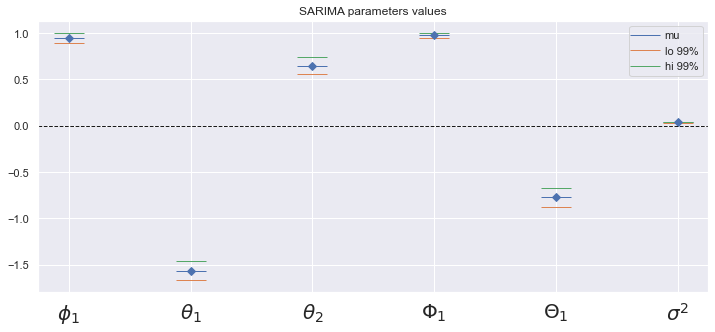

In [27]:
fig, ax = plt.subplots(figsize=(12, 5))
s_pars_df.plot(ax=ax, marker='_', ms=30, ls='none')
s_pars_df.plot(ax=ax, y='mu', marker='D', ms=5, color='C0', ls='none', legend=False)
ax.axhline(0, color='k', lw=1, ls='--')
ax.set(
    xticks=range(6),
    title='SARIMA parameters values',
    xlabel=None
)
ax.set_xticklabels([
        '$\phi_1$', r'$\theta_1$', r'$\theta_2$', 
        '$\Phi_1$', '$\Theta_1$', '$\sigma^2$',
    ], fontsize=20
)
plt.show()

Il modello migliore è molto semplice e con buone caratteristiche.

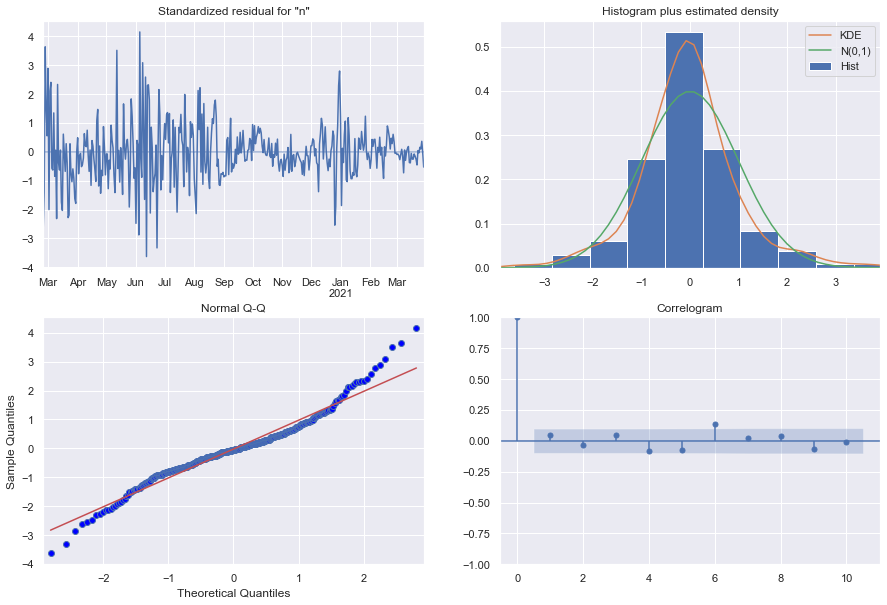

In [28]:
sarimax.plot_diagnostics(figsize=(15,10));

In [29]:
Markdown(f"""
Essendo molti ampi gli intervalli di confidenza 
delle previsioni, è stato scelto un intervallo del {CI:.0%}.
""")


Essendo molti ampi gli intervalli di confidenza 
delle previsioni, è stato scelto un intervallo del 50%.


In [30]:
#pa.tsdisplay(ts_log_detrend, lag_max=50)

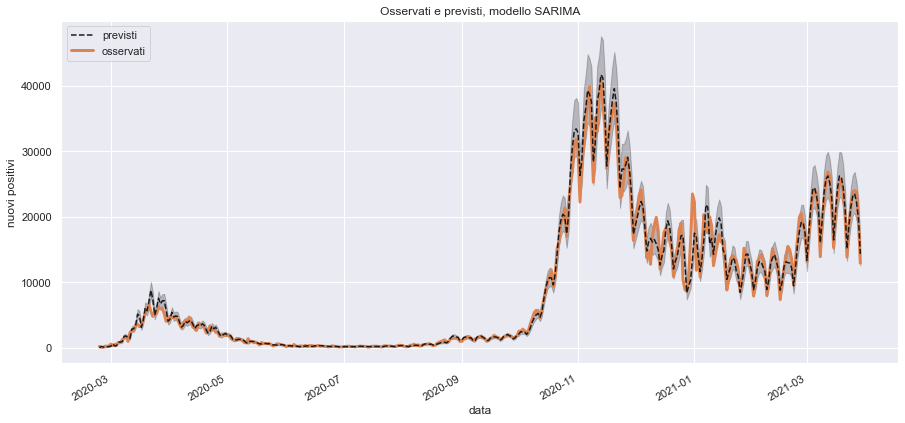

In [31]:
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(
    predict_past.index, predict_past.mu,
    ls='--', zorder=100,
    color='k', label='previsti',
)
ax.fill_between(
    predict_past.index,
    predict_past.lo, predict_past.hi,
    alpha=.25, color='k'
)
df.nuovi_positivi.plot(ax=ax, lw=3, label='osservati', color='C1')
ax.legend(loc='upper left')
ax.set(
    title='Osservati e previsti, modello SARIMA',
    ylabel='nuovi positivi'
)
plt.show()

In [32]:
sarimax_R2 = r2_score(ts.nuovi_positivi.values, predict_past.mu)

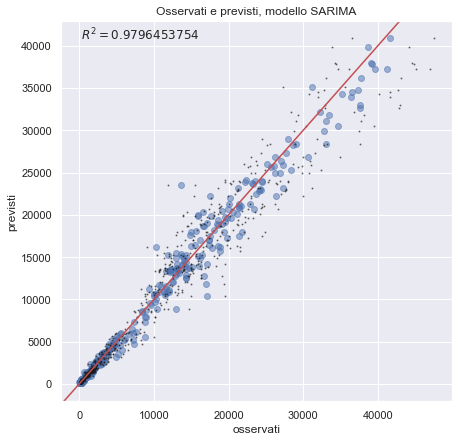

In [33]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(
    predict_past.mu, ts.nuovi_positivi.values,
    marker='o', ls='none', alpha=.5
)

ax.plot(
    predict_past.lo, ts.nuovi_positivi.values,
    marker='.', ms=2, ls='none', alpha=.5, color='k'
)
ax.plot(
    predict_past.hi, ts.nuovi_positivi.values,
    marker='.', ms=2, ls='none', alpha=.5, color='k'
)

ax.axline(xy1=(0, 0), slope=1, color='r')
ax.text(
    .05, .95,
    f"$R^2 = {sarimax_R2:.10f}$",
    transform=ax.transAxes
)
ax.set(
    xlabel='osservati',
    ylabel='previsti',
    title='Osservati e previsti, modello SARIMA'
)
plt.show()